## Import libraries

In [ ]:
# !pip install opencv-python
# !pip install tqdm
# !pip install torch
# !pip install torchvision
# !pip install timm
# !pip install tabulate


import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import torch
import torchvision
import timm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.v2 as t
from torchvision import models
import torch.nn as nn
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.nn.functional as F
from tabulate import tabulate
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import timm
from torch.optim.lr_scheduler import ReduceLROnPlateau

## Read train & test data

In [ ]:
train_dir = 'train' #'/Users/sampathsilla/Desktop/MSBA_FALL23/Advanced ML/Project/train'
test_dir = 'test' #/Users/sampathsilla/Desktop/MSBA_FALL23/Advanced ML/Project/test'

In [ ]:
import pandas as pd
train=pd.read_csv('train.csv')
train.head()

Image  Class
0  D3_405.jpg      0
1  D3_523.jpg      0
2  D3_750.jpg      0
3  D3_427.jpg      0
4  D3_042.jpg      0

In [ ]:
train.shape

(840, 2)

In [ ]:
import pandas as pd
test=pd.read_csv('test.csv')
test.head()

ID       Image
0   1  D3_693.jpg
1   2  D3_212.jpg
2   3  D3_724.jpg
3   4  D3_623.jpg
4   5  D3_210.jpg

In [ ]:
test.shape

(180, 2)

## EDA

In [ ]:
# Check the distribution of D3 and D5 images
train['Type'] = train['Image'].str.split('_').str[0]
test['Type'] = test['Image'].str.split('_').str[0]

In [ ]:
print('Train Data')
print(train['Type'].value_counts())
print('-' * 50)
print('Test Data')
print(test['Type'].value_counts())

Train Data
D3    560
D5    280
Name: Type, dtype: int64
--------------------------------------------------
Test Data
D3    120
D5     60
Name: Type, dtype: int64


[716 124]


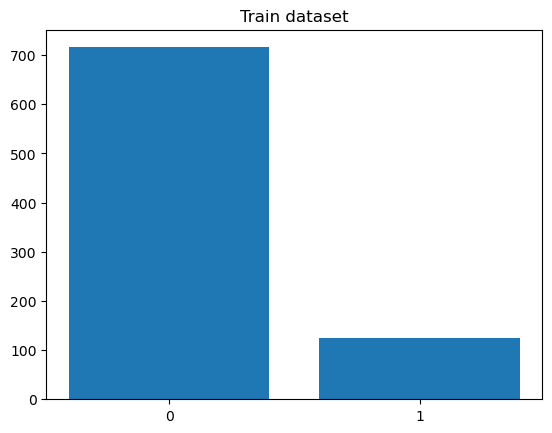

In [ ]:
# all data visualization
labels = train['Class'].value_counts()
plt.bar(['0','1'], labels.values)
print(labels.values)
plt.title('Train dataset')
plt.show()

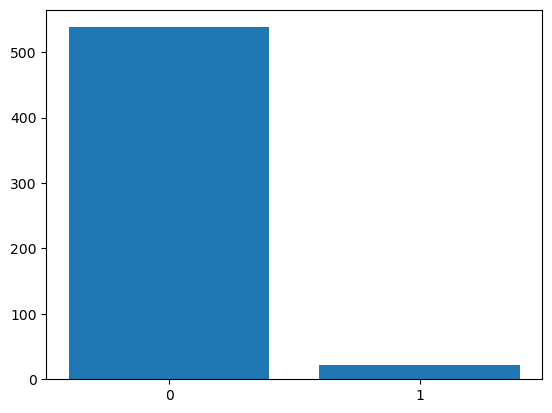

[538  22]


In [ ]:
#contain D3 images
D3 = train['Image'].apply(lambda x: 'D3_' in x)
labels = train[D3]['Class'].value_counts()
plt.bar(['0','1'], labels.values)
plt.show()
print(labels.values)

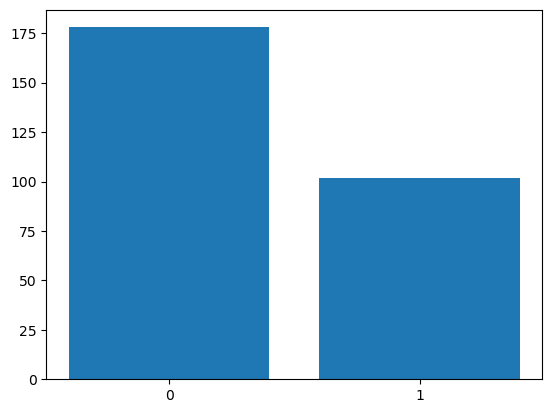

[178 102]


In [ ]:
#contain D5 images
D5 = train['Image'].apply(lambda x: 'D5_' in x)
labels = train[D5]['Class'].value_counts()
plt.bar(['0','1'], labels.values)
plt.show()
print(labels.values)

In [ ]:
from sklearn.utils import shuffle

# Shuffle the dataset
train = shuffle(train, random_state=42)

# Load sample images
num_samples = 10
class0_image_paths = [os.path.join(train_dir, image_name) for image_name in train[(train['Type'] == 'D3') & (train['Class'] == 0)]['Image'].head(num_samples)]
class1_image_paths = [os.path.join(train_dir, image_name) for image_name in train[(train['Type'] == 'D3') & (train['Class'] == 1)]['Image'].head(num_samples)]

class0_images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in class0_image_paths]
class1_images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in class1_image_paths]

# Calculate and display mean and std of the images
image_means = np.mean(np.concatenate([np.mean(img, axis=(0, 1)) for img in class0_images + class1_images], axis=0), axis=0)
image_stds = np.std(np.concatenate([np.std(img, axis=(0, 1)) for img in class0_images + class1_images], axis=0), axis=0)

print(f"Mean values for each channel: {image_means}")
print(f"Standard deviation values for each channel: {image_stds}")

Mean values for each channel: 167.08047042788596
Standard deviation values for each channel: 5.635324495597758


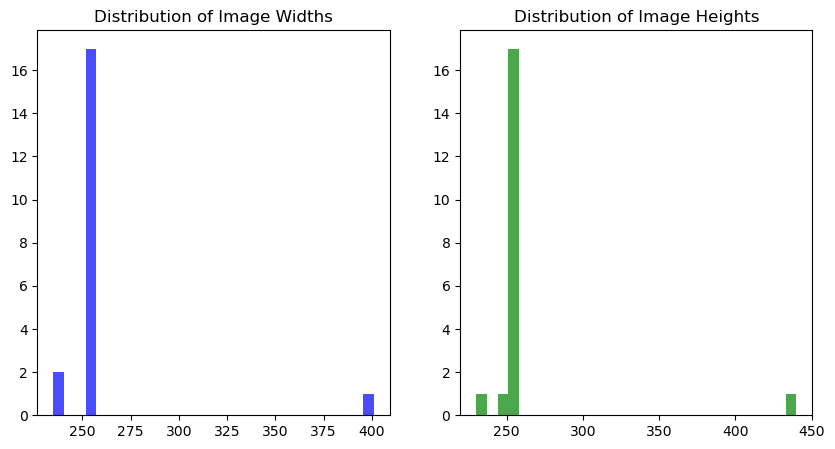

In [ ]:
# Example: Display histogram of image widths and heights
image_sizes = np.array([img.shape[:2] for img in class0_images + class1_images])
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(image_sizes[:, 0], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Image Widths')
plt.subplot(1, 2, 2)
plt.hist(image_sizes[:, 1], bins=30, color='green', alpha=0.7)
plt.title('Distribution of Image Heights')
plt.show()

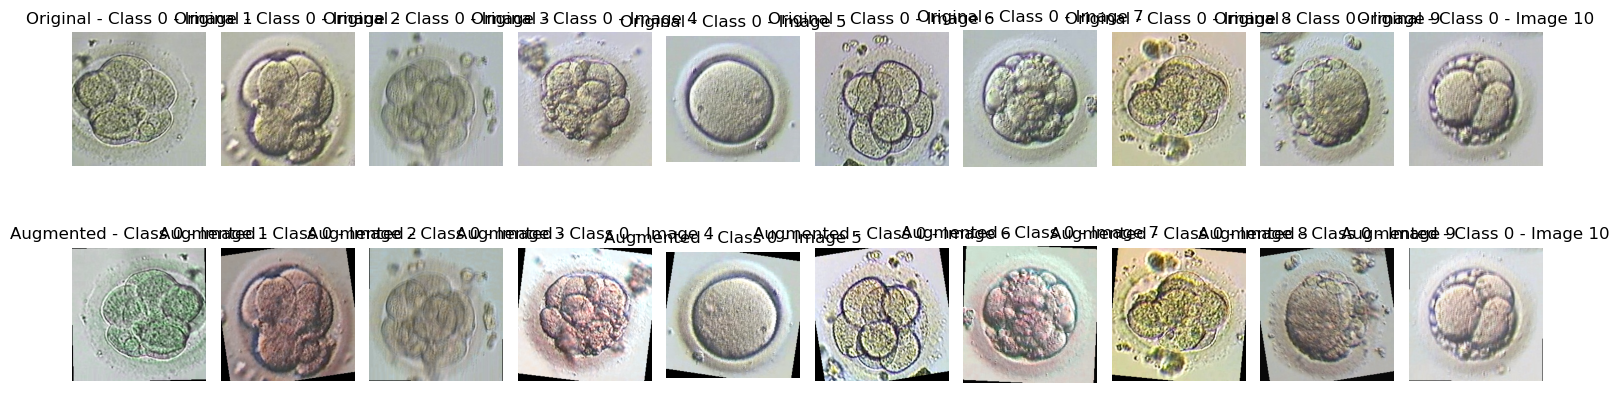

In [ ]:
# Example: Display augmented images
from torchvision import transforms
from torchvision.transforms import functional as F

augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    ax = plt.subplot(2, num_samples, i + 1)
    original_img = class0_images[i]
    ax.imshow(original_img)
    ax.set_title(f"Original - Class 0 - Image {i+1}")
    ax.axis('off')

    ax = plt.subplot(2, num_samples, i + 1 + num_samples)
    augmented_img = F.to_pil_image(augmentation_transform(F.to_tensor(original_img)))
    ax.imshow(augmented_img)
    ax.set_title(f"Augmented - Class 0 - Image {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()


## Comparison of Good & Not good embryo images

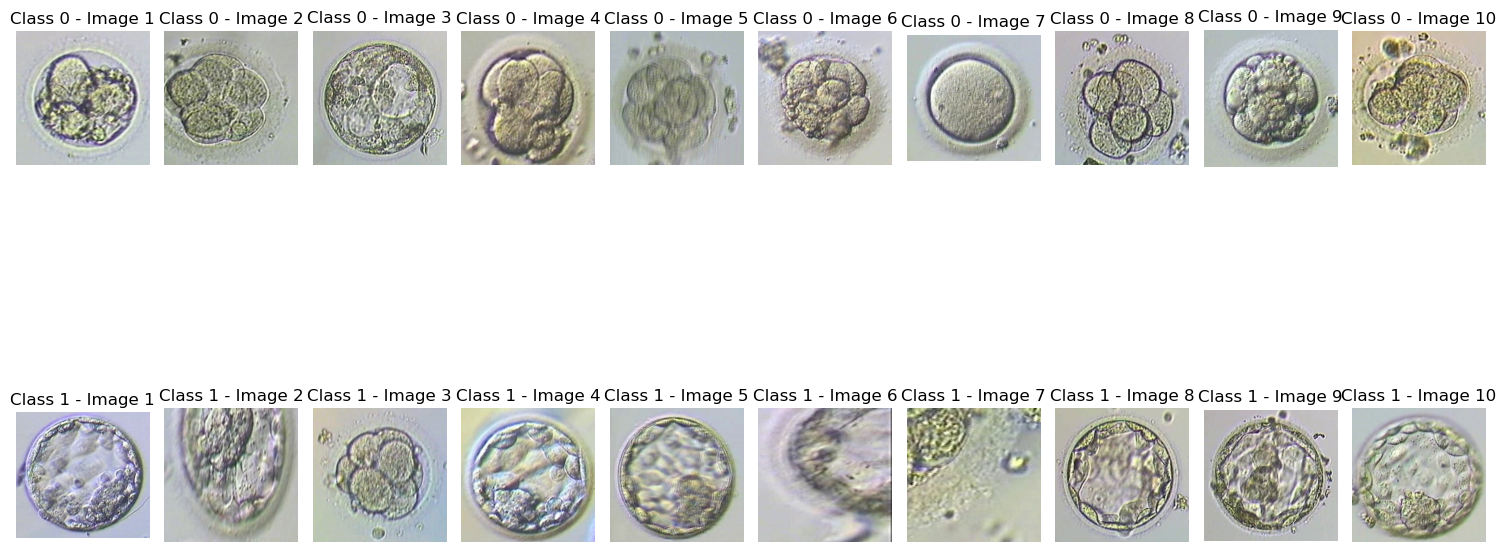

In [ ]:
# Number of sample images to display for each class
num_samples = 10

# Get the paths for the first 6 images of each class
class0_image_paths = [os.path.join(train_dir, image_name) for image_name in train[train['Class'] == 0]['Image'].head(num_samples)]
class1_image_paths = [os.path.join(train_dir, image_name) for image_name in train[train['Class'] == 1]['Image'].head(num_samples)]

# Load the images
class0_images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in class0_image_paths]
class1_images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in class1_image_paths]

# Display the images
plt.figure(figsize=(15, 10))

# Plot images from Class 0
for i, image in enumerate(class0_images, 1):
    plt.subplot(2, num_samples, i)
    plt.imshow(image)
    plt.title(f"Class 0 - Image {i}")
    plt.axis('off')

# Plot images from Class 1
for i, image in enumerate(class1_images, 1):
    plt.subplot(2, num_samples, i + num_samples)
    plt.imshow(image)
    plt.title(f"Class 1 - Image {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Compare D3 & D5 embryo images

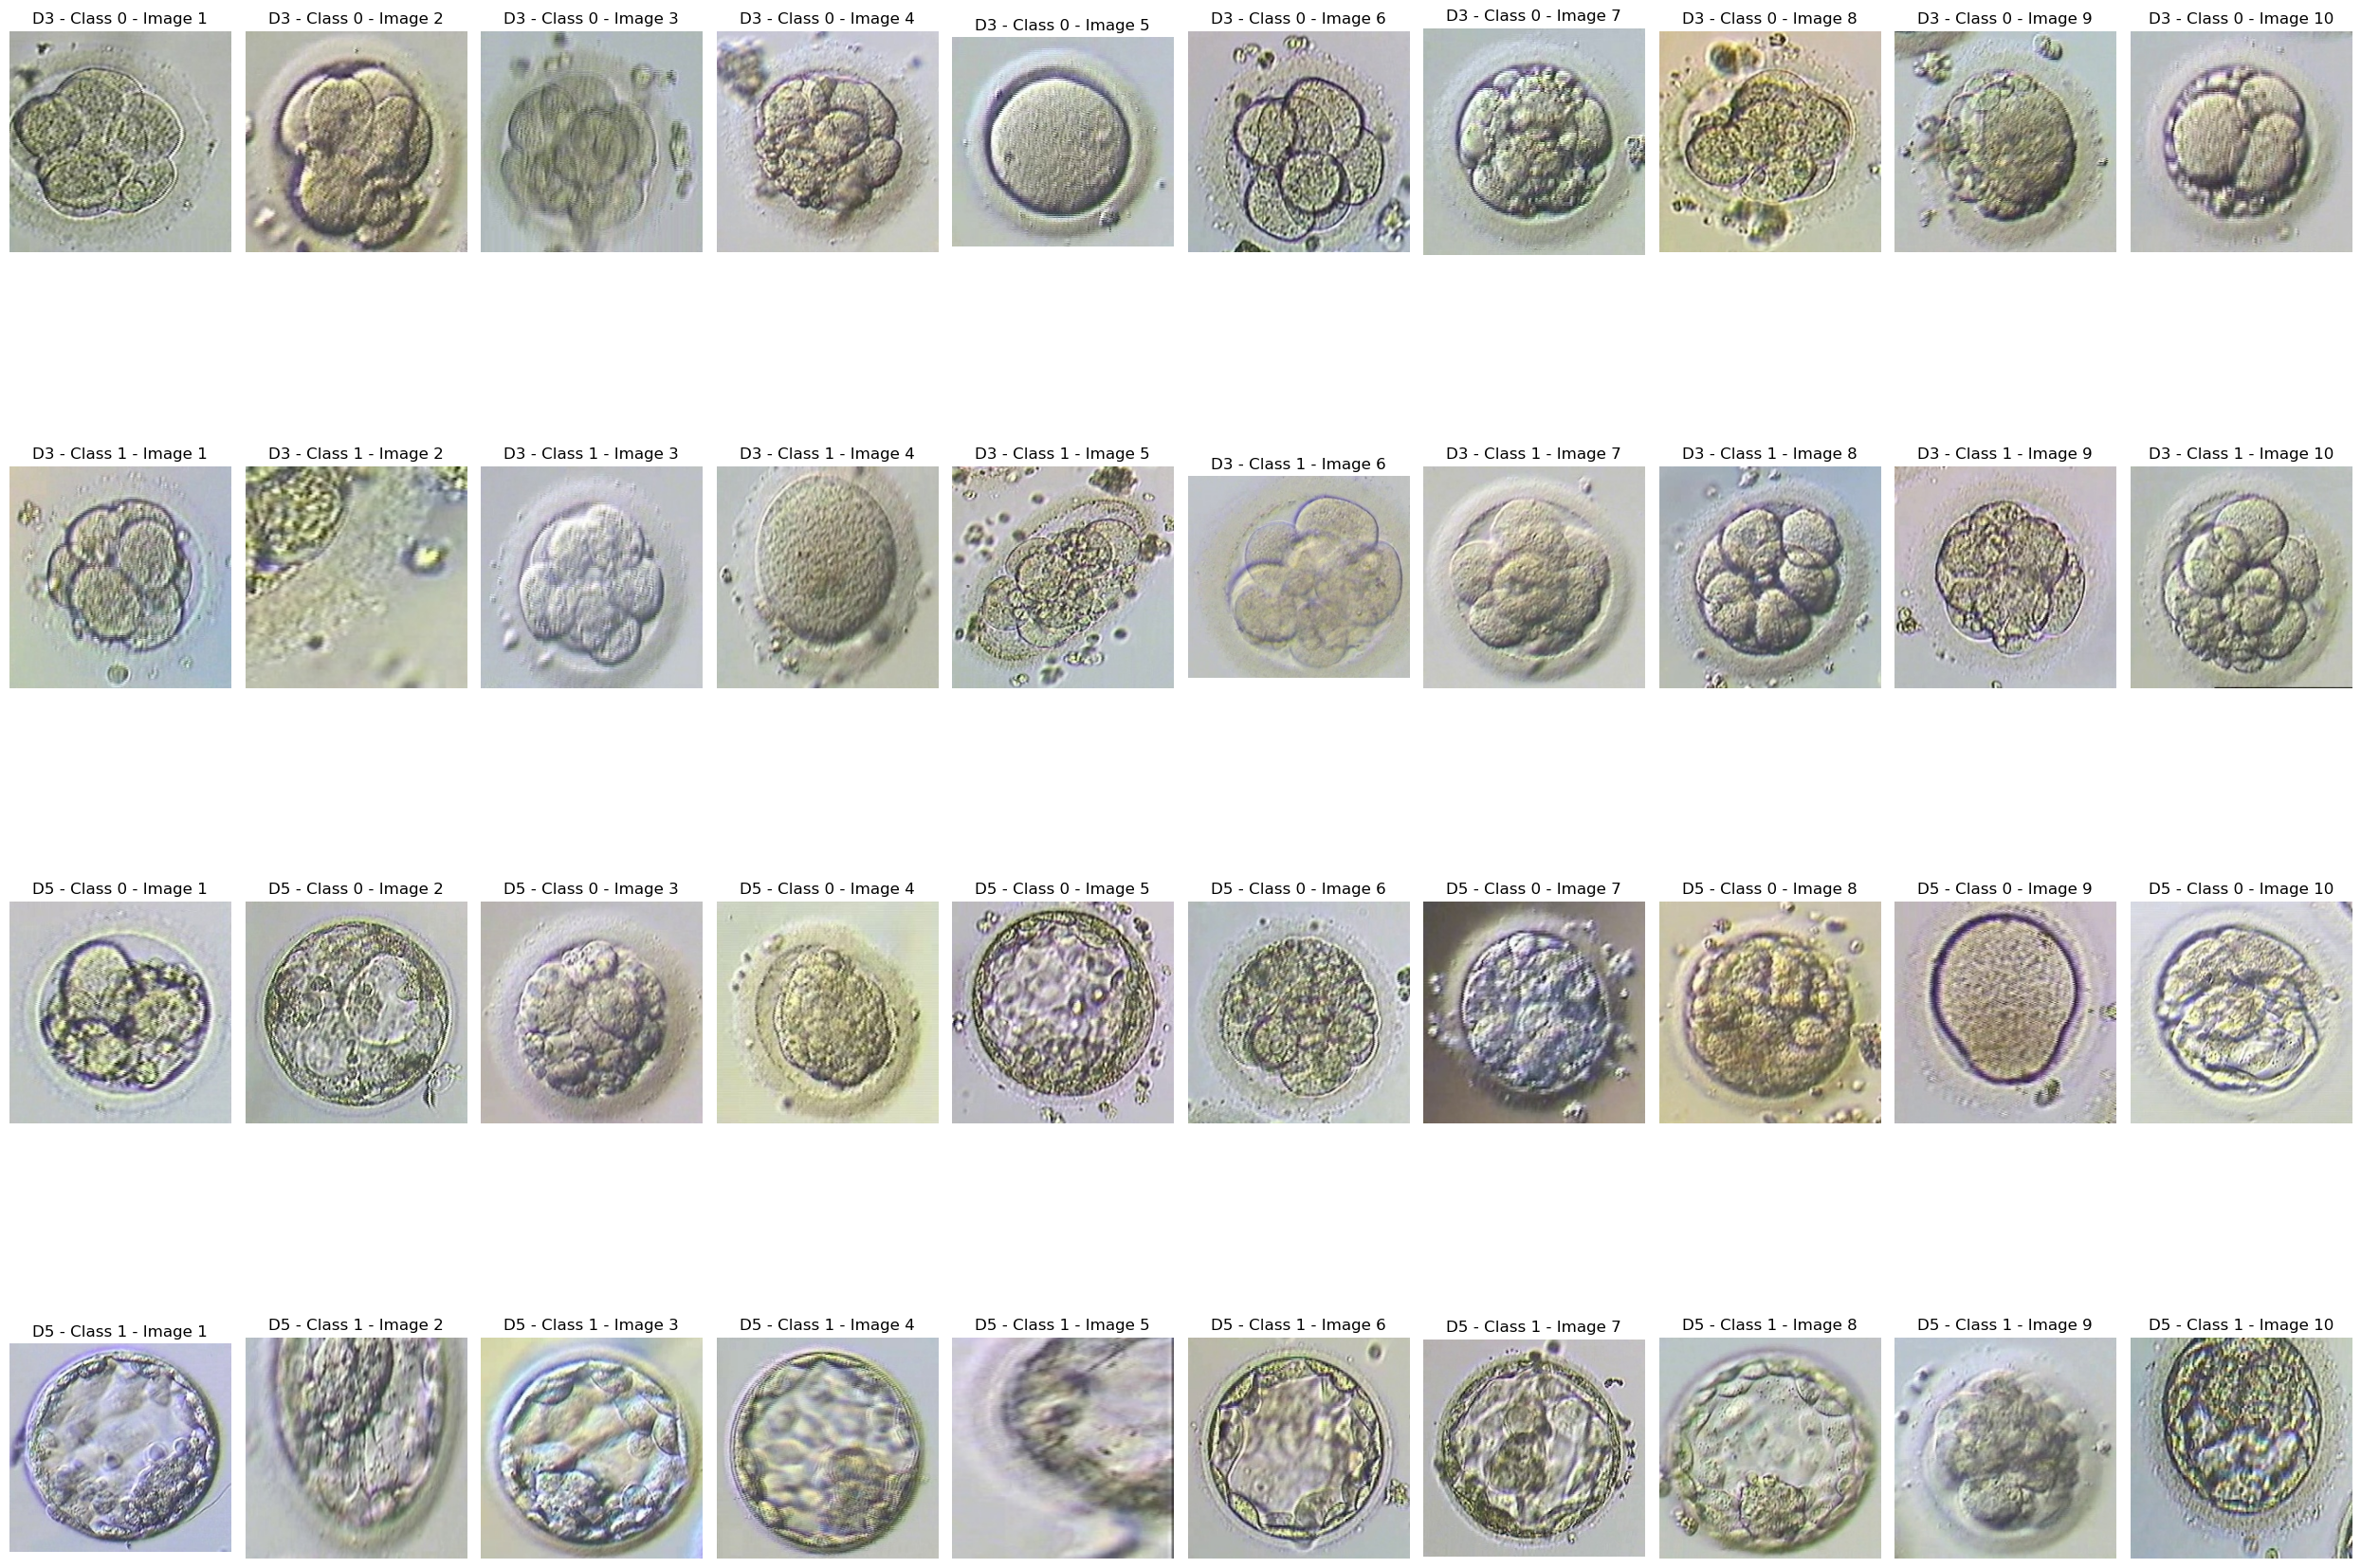

In [ ]:
# Paths for images based on type and class
d3_class0_image_paths = [os.path.join(train_dir, image_name) for image_name in train[(train['Image'].str.startswith('D3')) & (train['Class'] == 0)]['Image'].head(num_samples)]
d3_class1_image_paths = [os.path.join(train_dir, image_name) for image_name in train[(train['Image'].str.startswith('D3')) & (train['Class'] == 1)]['Image'].head(num_samples)]
d5_class0_image_paths = [os.path.join(train_dir, image_name) for image_name in train[(train['Image'].str.startswith('D5')) & (train['Class'] == 0)]['Image'].head(num_samples)]
d5_class1_image_paths = [os.path.join(train_dir, image_name) for image_name in train[(train['Image'].str.startswith('D5')) & (train['Class'] == 1)]['Image'].head(num_samples)]

# Load the images
d3_class0_images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in d3_class0_image_paths]
d3_class1_images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in d3_class1_image_paths]
d5_class0_images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in d5_class0_image_paths]
d5_class1_images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in d5_class1_image_paths]

# Display the images
plt.figure(figsize=(25, 20))

# Plot images from D3 type with Class 0
for i, image in enumerate(d3_class0_images, 1):
    plt.subplot(4, num_samples, i)
    plt.imshow(image)
    plt.title(f"D3 - Class 0 - Image {i}")
    plt.axis('off')

# Plot images from D3 type with Class 1
for i, image in enumerate(d3_class1_images, 1):
    plt.subplot(4, num_samples, i + num_samples)
    plt.imshow(image)
    plt.title(f"D3 - Class 1 - Image {i}")
    plt.axis('off')

# Plot images from D5 type with Class 0
for i, image in enumerate(d5_class0_images, 1):
    plt.subplot(4, num_samples, i + 2*num_samples)
    plt.imshow(image)
    plt.title(f"D5 - Class 0 - Image {i}")
    plt.axis('off')

# Plot images from D5 type with Class 1
for i, image in enumerate(d5_class1_images, 1):
    plt.subplot(4, num_samples, i + 3*num_samples)
    plt.imshow(image)
    plt.title(f"D5 - Class 1 - Image {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Preprocessing

In [ ]:
!pip install tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

# Define the image size
IMG_SIZE = (224, 224)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

# Define the image size
IMG_SIZE = (224, 224)

# Initialize data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Split the dataframe based on classes
class_0_df = train[train["Class"] == 0]
class_1_df = train[train["Class"] == 1]

# Sample half of the validation data from each class
valid_class_0 = class_0_df.sample(n=50, random_state=42)
valid_class_1 = class_1_df.sample(n=50, random_state=42)

# Concatenate the samples to create the validation dataframe
valid_df = pd.concat([valid_class_0, valid_class_1], axis=0)

# Update train_df by removing the validation samples
train = train.drop(valid_df.index)

# Shuffle the training dataframe
train = shuffle(train, random_state=42)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=train_dir,
    x_col="Image",
    y_col="Class",
    class_mode="raw",
    target_size=IMG_SIZE,
    batch_size=16,
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=train_dir,
    x_col="Image",
    y_col="Class",
    class_mode="raw",
    target_size=IMG_SIZE,
    batch_size=16,
    shuffle=False
)

Found 740 validated image filenames.
Found 100 validated image filenames.


Unique labels in train_generator: (array([0, 1], dtype=int64), array([666,  74], dtype=int64))
Unique labels in valid_generator: (array([0, 1], dtype=int64), array([50, 50], dtype=int64))


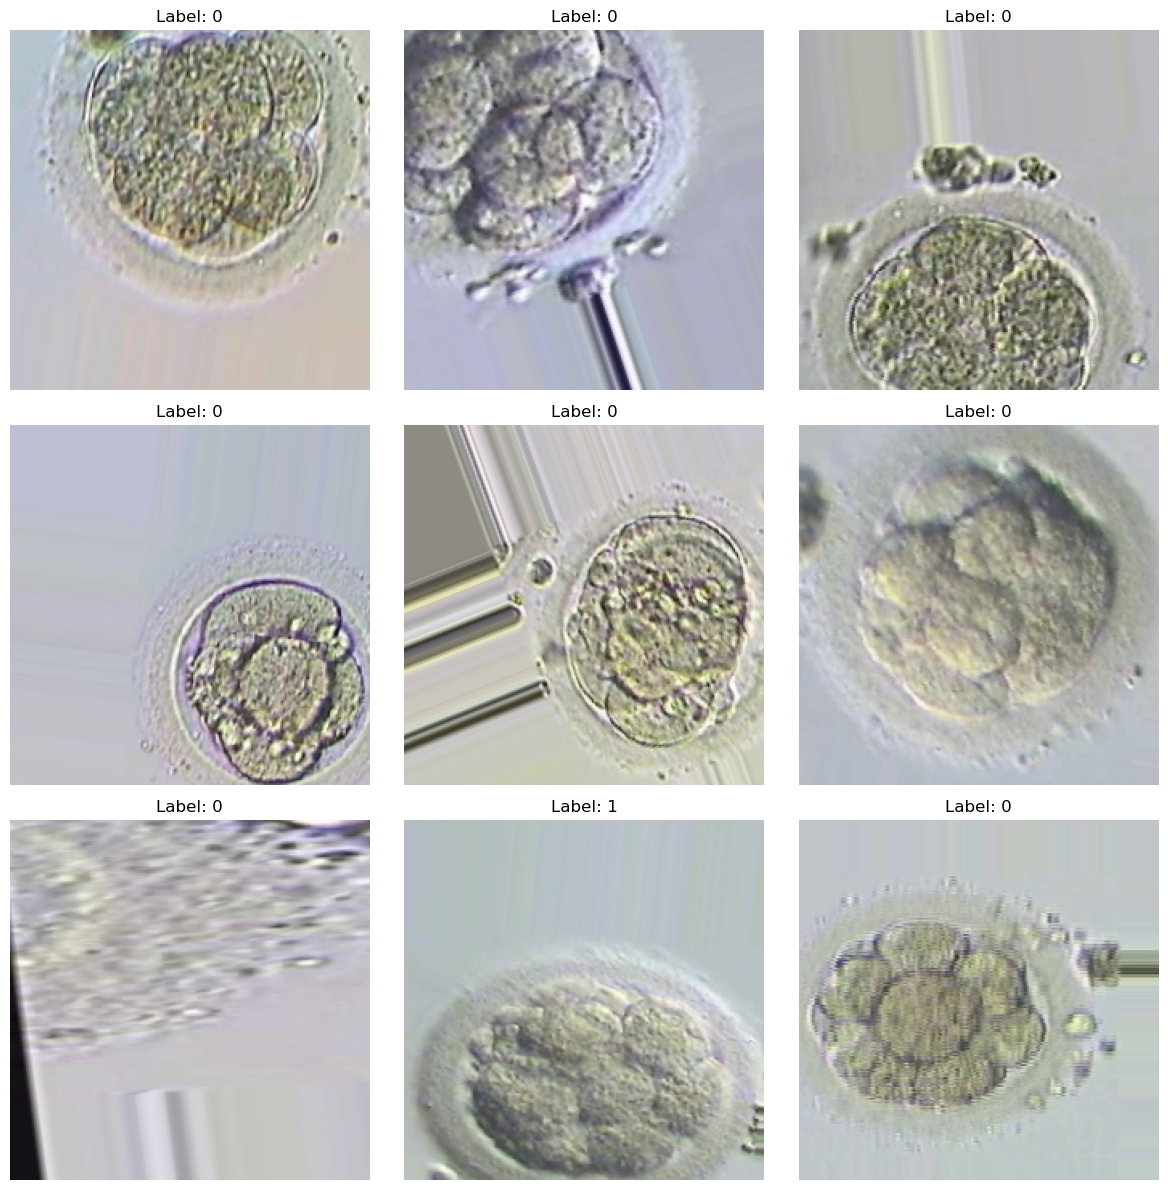

In [ ]:
# Check labels in train_generator
train_labels = train_generator.labels

# Check labels in valid_generator
valid_labels = valid_generator.labels

# Print unique labels and their counts
print("Unique labels in train_generator:", np.unique(train_labels, return_counts=True))
print("Unique labels in valid_generator:", np.unique(valid_labels, return_counts=True))
import matplotlib.pyplot as plt

# Get a batch of images and labels from train_generator
images, labels = next(train_generator)

# Plot some images from the batch
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Modelling

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import Recall
from tensorflow.keras.applications import MobileNetV3Large

In [ ]:
unique_labels = train['Class'].unique()
print(unique_labels)

[0 1]


In [ ]:
x_batch, y_batch = next(train_generator)
unique_labels = set(y_batch)
print(unique_labels)

{0, 1}


In [ ]:
# Using DataFrame
is_one_hot_encoded = train['Class'].apply(lambda x: isinstance(x, list) or isinstance(x, np.ndarray)).any()
print(f"Labels are one-hot encoded: {is_one_hot_encoded}")

# Using Generator
is_one_hot_encoded = any(isinstance(label, list) or isinstance(label, np.ndarray) for label in y_batch)
print(f"Labels are one-hot encoded: {is_one_hot_encoded}")

Labels are one-hot encoded: False
Labels are one-hot encoded: False


Training on CPU.
Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 0.7253 - accuracy: 0.5027

C:\Users\Simran\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 27s 495ms/step - loss: 0.7253 - accuracy: 0.5027 - val_loss: 0.6936 - val_accuracy: 0.4400 - lr: 1.0000e-04
Epoch 2/50
47/47 [==============================] - 19s 405ms/step - loss: 0.7375 - accuracy: 0.4541 - val_loss: 0.6936 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/50
47/47 [==============================] - 19s 404ms/step - loss: 0.7390 - accuracy: 0.5419 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/50
47/47 [==============================] - 19s 395ms/step - loss: 0.7158 - accuracy: 0.4959 - val_loss: 0.6953 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/50
47/47 [==============================] - 19s 408ms/step - loss: 0.7425 - accuracy: 0.4959 - val_loss: 0.6929 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/50
47/47 [==============================] - 19s 403ms/step - loss: 0.7112 - accuracy: 0.4932 - val_loss: 0.6927 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 7/50
47/47 [==============================] -

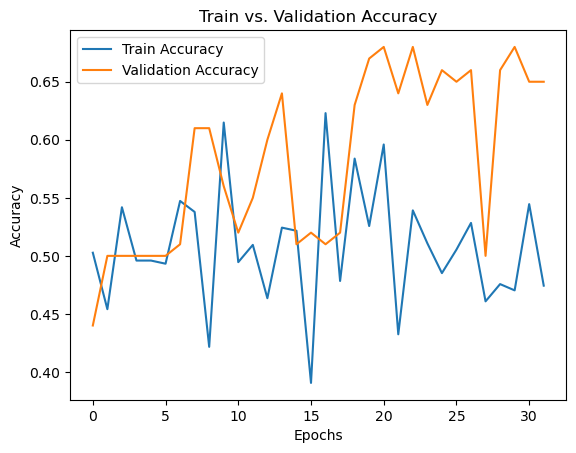

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV3Large
# Define the image size
IMG_SIZE = (224, 224)

# ... [The rest of the data generators code remains unchanged]

# Check if GPU is available
if tf.config.experimental.list_physical_devices('GPU'):
    print('Training on GPU.')
    device = '/GPU:0'
else:
    print('Training on CPU.')
    device = '/CPU:0'

with tf.device(device):
    # Load pre-trained ResNet50 model
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Build additional layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Define early stopping, learning rate scheduler, and model checkpoint
    early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=11, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=0.00001)
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    class_weights = compute_class_weight('balanced', classes=[0, 1], y=train['Class'])
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    # Train the model
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=valid_generator,
        callbacks=[early_stop, model_checkpoint, lr_scheduler],
        class_weight=class_weight_dict,
        verbose=1
    )

# Plot training vs. validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs. Validation Accuracy')
plt.show()

7/7 [==============================] - 3s 258ms/step


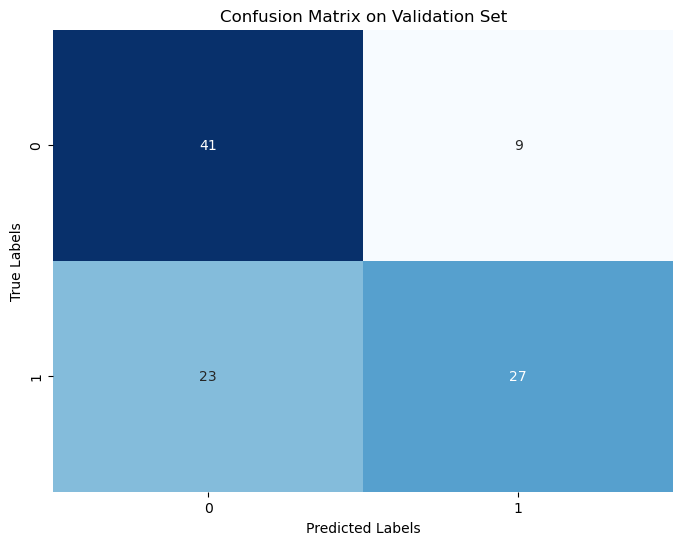

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Use the trained model to make predictions on the validation set
valid_generator.reset()  # Reset the generator to be sure of the order
valid_predictions = model.predict(valid_generator)
valid_labels_predicted = [1 if pred > 0.5 else 0 for pred in valid_predictions]

# Extract the true labels from the validation generator
valid_labels_true = valid_generator.labels

# Generate the confusion matrix
cm = confusion_matrix(valid_labels_true, valid_labels_predicted)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Validation Set')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict classes on validation set
valid_generator.reset()
valid_preds = model.predict(valid_generator)
valid_preds_binary = [1 if pred > 0.5 else 0 for pred in valid_preds]

# Compute metrics
precision = precision_score(valid_generator.labels, valid_preds_binary)
recall = recall_score(valid_generator.labels, valid_preds_binary)
f1 = f1_score(valid_generator.labels, valid_preds_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

7/7 [==============================] - 2s 252ms/step
Precision: 0.7500
Recall: 0.5400
F1-Score: 0.6279


In [ ]:
# Preprocess test images using an ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=test_dir,
    x_col="Image",
    y_col=None,
    class_mode=None,
    target_size=IMG_SIZE,
    batch_size=32,
    shuffle=False
)

# Use the trained model to make predictions on the test set
test_predictions = model.predict(test_generator)

# Convert predictions to binary labels
test_labels = [1 if pred > 0.5 else 0 for pred in test_predictions]

# Prepare the submission dataframe
submission_df = test[['ID']].copy()
submission_df['Class'] = test_labels

# Save the submission dataframe to a CSV file
submission_file_path = 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)

Found 180 validated image filenames.
6/6 [==============================] - 4s 530ms/step


# SSIM

In [ ]:
import tensorflow as tf
from tensorflow.image import ssim

# Function to calculate SSIM loss
def ssim_loss(y_true, y_pred):
    # Ensure images are in the range [0, 1]
    y_true = tf.clip_by_value(y_true, 0.0, 1.0)
    y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)

    # Calculate SSIM
    ssim_value = ssim(y_true, y_pred, max_val=1.0)

    # Return SSIM loss (1 - SSIM to use as a loss)
    return ssim_value



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torchvision import transforms


i = 0
mean_loss_d3 = []
count_greater_than_075_d3 = []

train_d3, test_d3  =  train_test_split(train[train['Image'].str.startswith('D3')], test_size=0.25, random_state=42)

d3_class1_images = [os.path.join(train_dir, image_name) for image_name in train[(train['Image'].str.startswith('D3')) & (train['Class'] == 1)]['Image']]

d3_class1_images_test = [os.path.join(train_dir, image_name) for image_name in test_d3[test_d3['Image'].str.startswith('D3')]['Image']]

for image_path_pred in d3_class1_images_test:
    losses = []
    for image_path_true in d3_class1_images:

        height, width = 256,256

        augmentation_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),])

        # Load and preprocess the true image
        img_true = image.load_img(image_path_true, target_size=(height, width))
        img_true = F.to_pil_image(augmentation_transform(F.to_tensor(img_true)))  #aug
        img_array_true = image.img_to_array(img_true)
        img_array_true /= 255.0  # Normalize to [0, 1]

        # Load and preprocess the predicted image
        img_pred = image.load_img(image_path_pred, target_size=(height, width))
        img_pred = F.to_pil_image(augmentation_transform(F.to_tensor(img_pred)))  #aug
        img_array_pred = image.img_to_array(img_pred)
        img_array_pred /= 255.0  # Normalize to [0, 1]




        y_true = tf.constant(img_array_true)  # Your ground truth image
        y_pred = tf.constant(img_array_pred)  # Your predicted image


        loss = ssim_loss(y_true, y_pred)
        losses.append(loss.numpy())


    mean_loss_d3.append(np.mean(losses))
#     greater_than_075 = losses > 0.75
    count_greater_than_075_d3.append(np.sum(np.array(losses) > 0.75))



In [ ]:
d3_test_df =  pd.DataFrame({'Image': d3_class1_images_test, 'Mean Loss': mean_loss_d3, 'Similarity Count': count_greater_than_075_d3})
d3_test_df['Label'] = np.where(d3_test_df['Similarity Count']>5,1,0)
d3_test_df['Image'] = d3_test_df['Image'].str.replace(r'train\\', '')

d3_test_df.sort_values(by = 'Image', inplace = True)

d3_test_df_merged = pd.merge(d3_test_df, train, left_on='Image', right_on='Image', how='left')
d3_test_df_merged

C:\Users\Simran\AppData\Local\Temp\ipykernel_17400\3167052679.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  d3_test_df['Image'] = d3_test_df['Image'].str.replace(r'train\\', '')


Image  Mean Loss  Similarity Count  Label  Class Type
0    D3_001.jpg   0.250906                 0      0      0   D3
1    D3_004.jpg   0.194695                 0      0      0   D3
2    D3_020.jpg   0.216830                 0      0      0   D3
3    D3_022.jpg   0.247428                 0      0      0   D3
4    D3_025.jpg   0.200158                 0      0      0   D3
..          ...        ...               ...    ...    ...  ...
124  D3_764.jpg   0.306516                 0      0      0   D3
125  D3_766.jpg   0.342835                 0      0      0   D3
126  D3_769.jpg   0.282136                 0      0      0   D3
127  D3_781.jpg   0.292804                 0      0      0   D3
128  D3_792.jpg   0.254669                 0      0      0   D3

[129 rows x 6 columns]

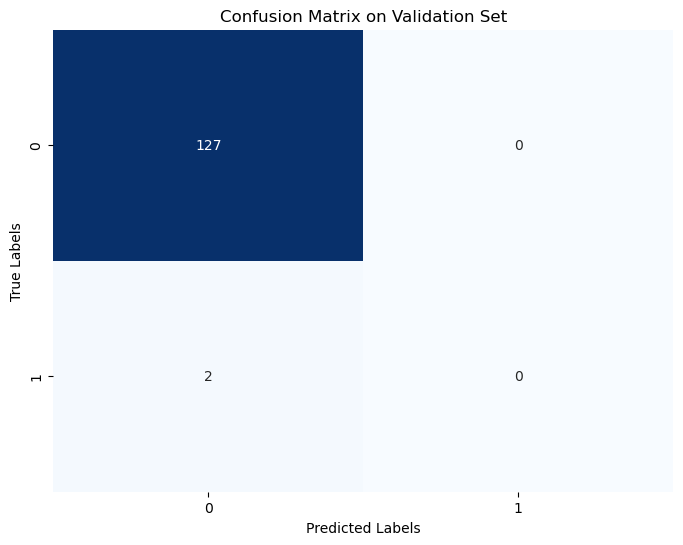

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate the confusion matrix
cm = confusion_matrix(d3_test_df_merged['Class'], d3_test_df_merged['Label'])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Validation Set')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
from sklearn.model_selection import train_test_split

# Assuming ssim_loss and class_1_df_day3 are defined earlier in your code

# Example usage with TensorFlow
# Assuming y_true_batch and y_pred_batch are your batches of ground truth and predicted images as TensorFlow Tensors
# Note: Make sure the images are in the range [0, 1]

# Load and preprocess your images (replace 'path/to/image' with the actual file paths)
i = 0
mean_loss_d5 = []
count_greater_than_075_d5 = []

train_d5, test_d5  =  train_test_split(train[train['Image'].str.startswith('D5')], test_size=0.25, random_state=42)

d5_class1_images = [os.path.join(train_dir, image_name) for image_name in train[(train['Image'].str.startswith('D5')) & (train['Class'] == 1)]['Image']]

d5_class1_images_test = [os.path.join(train_dir, image_name) for image_name in test_d5[test_d5['Image'].str.startswith('D5')]['Image']]

for image_path_pred in d5_class1_images_test:
    losses = []
#     print(image_path_pred)
    for image_path_true in d5_class1_images:

        height, width = 256,256

        augmentation_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),])

        # Load and preprocess the true image
        img_true = image.load_img(image_path_true, target_size=(height, width))
        img_true = F.to_pil_image(augmentation_transform(F.to_tensor(img_true)))  #aug
        img_array_true = image.img_to_array(img_true)
        img_array_true /= 255.0  # Normalize to [0, 1]

        # Load and preprocess the predicted image
        img_pred = image.load_img(image_path_pred, target_size=(height, width))
        img_pred = F.to_pil_image(augmentation_transform(F.to_tensor(img_pred)))  #aug
        img_array_pred = image.img_to_array(img_pred)
        img_array_pred /= 255.0  # Normalize to [0, 1]



#         augmented_img = F.to_pil_image(augmentation_transform(F.to_tensor(original_img)))

        y_true = tf.constant(img_array_true)  # Your ground truth image
        y_pred = tf.constant(img_array_pred)  # Your predicted image


        loss = ssim_loss(y_true, y_pred)
        losses.append(loss.numpy())

#         print("SSIM Loss for image {} is {}:".format(image_path_true,loss.numpy()))

# Update the DataFrame column in a vectorized way
#     class_1_df_day5['Loss'] = losses
    mean_loss_d5.append(np.mean(losses))
#     greater_than_075 = losses > 0.75
    count_greater_than_075_d5.append(np.sum(np.array(losses) > 0.75))



In [ ]:
# d5_class1_images_test = ['train\\D5_158.jpg', 'train\\D5_348.jpg', 'train\\D5_176.jpg', 'train\\D5_146.jpg', 'train\\D5_259.jpg']
d5_test_df =  pd.DataFrame({'Image': d5_class1_images_test, 'Mean Loss': mean_loss_d5, 'Similarity Count': count_greater_than_075_d5})
d5_test_df['Label'] = np.where(d5_test_df['Similarity Count']>11,1,0)
d5_test_df['Image'] = d5_test_df['Image'].str.replace(r'train\\', '')

d5_test_df.sort_values(by = 'Image', inplace = True)

d5_test_df_merged = pd.merge(d5_test_df, train, left_on='Image', right_on='Image', how='left')
d5_test_df_merged

C:\Users\Simran\AppData\Local\Temp\ipykernel_17400\1205193468.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  d5_test_df['Image'] = d5_test_df['Image'].str.replace(r'train\\', '')


Image  Mean Loss  Similarity Count  Label  Class Type
0   D5_005.jpg   0.185814                 0      0      0   D5
1   D5_007.jpg   0.215053                 0      0      0   D5
2   D5_021.jpg   0.268992                 0      0      0   D5
3   D5_025.jpg   0.261919                 0      0      0   D5
4   D5_036.jpg   0.237607                 0      0      0   D5
5   D5_041.jpg   0.235461                 0      0      0   D5
6   D5_049.jpg   0.213892                 0      0      0   D5
7   D5_054.jpg   0.219098                 0      0      0   D5
8   D5_059.jpg   0.213047                 0      0      0   D5
9   D5_075.jpg   0.196364                 0      0      1   D5
10  D5_084.jpg   0.217586                 0      0      0   D5
11  D5_086.jpg   0.212390                 0      0      0   D5
12  D5_098.jpg   0.159073                 0      0      0   D5
13  D5_099.jpg   0.186064                 0      0      1   D5
14  D5_110.jpg   0.214163                 0      0      0   D5
15  D5_137.jpg   0.236455                 0      0      0   D5
16  D5_146.jpg   0.192469                 0      0      1   D5
17  D5_151.jpg   0.249969                 0      0      0   D5
18  D5_161.jpg   0.166948                 0      0      0   D5
19  D5_162.jpg   0.162031                 0      0      0   D5
20  D5_176.jpg   0.210403                 0      0      1   D5
21  D5_184.jpg   0.167131                 0      0      0   D5
22  D5_188.jpg   0.217385                 0      0      0   D5
23  D5_190.jpg   0.182668                 0      0      0   D5
24  D5_191.jpg   0.173470                 0      0      0   D5
25  D5_195.jpg   0.206821                 0      0      0   D5
26  D5_202.jpg   0.191640                 0      0      1   D5
27  D5_206.jpg   0.263101                 0      0      1   D5
28  D5_212.jpg   0.223716                 0      0      0   D5
29  D5_216.jpg   0.181566                 0      0      1   D5
30  D5_220.jpg   0.253126                 0      0      1   D5
31  D5_222.jpg   0.251272                 0      0      0   D5
32  D5_225.jpg   0.229609                 0      0      1   D5
33  D5_229.jpg   0.207630                 0      0      1   D5
34  D5_231.jpg   0.235902                 0      0      0   D5
35  D5_239.jpg   0.190181                 0      0      0   D5
36  D5_245.jpg   0.202786                 0      0      0   D5
37  D5_246.jpg   0.205749                 0      0      0   D5
38  D5_252.jpg   0.205209                 0      0      0   D5
39  D5_255.jpg   0.228263                 0      0      1   D5
40  D5_264.jpg   0.218468                 0      0      0   D5
41  D5_270.jpg   0.201906                 0      0      0   D5
42  D5_287.jpg   0.202556                 0      0      0   D5
43  D5_297.jpg   0.229711                 0      0      0   D5
44  D5_308.jpg   0.198833                 0      0      0   D5
45  D5_327.jpg   0.198009                 0      0      1   D5
46  D5_328.jpg   0.318578                 0      0      1   D5
47  D5_332.jpg   0.155012                 0      0      1   D5
48  D5_338.jpg   0.189698                 0      0      0   D5
49  D5_358.jpg   0.233321                 0      0      0   D5
50  D5_366.jpg   0.217771                 0      0      1   D5
51  D5_367.jpg   0.184423                 0      0      1   D5
52  D5_376.jpg   0.270611                 0      0      0   D5
53  D5_379.jpg   0.247578                 0      0      1   D5
54  D5_391.jpg   0.256533                 0      0      0   D5
55  D5_400.jpg   0.214306                 0      0      0   D5

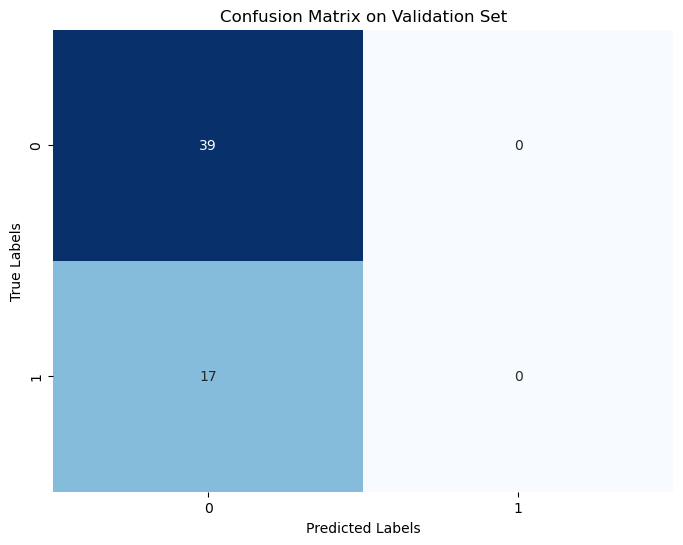

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(d5_test_df_merged['Class'], d5_test_df_merged['Label'])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Validation Set')
plt.show()